In [292]:
from kan import *

In [293]:
import torch

In [294]:
model = KAN(width=[2,5,1], grid=1, k=3, seed=0)

checkpoint directory created: ./model
saving model version 0.0


In [295]:
X_train = torch.randn(1000,2)
X_test = torch.randn(1000,2)

In [296]:
def weierstrass_function(x, a=.2, b=3, N=10):
    """
    Multivariate Weierstrass function in PyTorch.
    
    Args:
        x (torch.Tensor): A tensor of shape [100, 2], where each row represents a 2D point.
        a (float): Parameter a where 0 < a < 1.
        b (int): Parameter b (typically an odd integer).
        N (int): Number of terms in the sum.
        
    Returns:
        torch.Tensor: The computed Weierstrass function value for each point in x.
    """
    # Initialize the function value to zero
    W = torch.zeros(x.shape[0], dtype=x.dtype)
    norm_x = torch.norm(x, dim=1)
    
    # Iterate over the summation index n
    for n in range(N):
        # Compute the norm ||x||_2 (Euclidean norm for each row of the tensor)
        
        # Add the nth term to the sum
        if torch.isnan(b**n * torch.pi * norm_x).any():
            print(n)
        if torch.isinf(b**n * torch.pi * norm_x).any():
            print(n)
        W += a**n * torch.cos(b**n * torch.pi * norm_x)
    return W

In [297]:
f = lambda x: x[:,[0]] + x[:,[1]]

In [298]:
dataset = {
    "train_input": X_train,
    "train_label": weierstrass_function(X_train),
    "test_input":  X_test,
    "test_label": weierstrass_function(X_test)
}


In [299]:
dataset

{'train_input': tensor([[-0.6787,  0.9383],
         [ 0.4889, -0.6731],
         [ 0.8728,  1.0554],
         ...,
         [ 0.5502,  0.6043],
         [ 0.0740, -0.8004],
         [-0.0973, -1.5325]]),
 'train_label': tensor([-8.8997e-01, -8.6197e-01, -1.9900e-01,  4.1893e-01,  1.6800e-01,
          6.5455e-01,  3.5092e-01,  5.3364e-01,  1.8748e-01, -8.2828e-01,
         -1.2594e-01,  1.1892e+00,  2.5618e-02,  1.0266e+00, -5.0013e-01,
         -8.3207e-01, -9.3646e-01,  9.5887e-01, -1.0816e+00, -8.8973e-01,
         -2.1730e-01, -3.1301e-01, -1.2163e+00, -1.1765e+00, -7.5555e-01,
          3.9586e-01, -1.4921e-01, -2.4506e-01, -3.5358e-01, -1.2651e-02,
          2.2608e-01, -2.1157e-01, -6.6050e-03, -2.6051e-01,  1.3060e-01,
         -1.1915e+00,  1.4144e-01, -2.0588e-01,  1.2230e+00,  1.3990e-01,
         -1.0342e+00, -9.2253e-01, -1.0516e+00, -8.6268e-01, -6.4820e-01,
          5.5766e-01, -1.6202e-01, -5.9914e-01, -1.2398e+00, -1.2295e+00,
          4.9708e-01, -7.7881e-01, -2.20

In [300]:
dataset["train_label"].shape, dataset["train_input"].shape
dataset["test_input"].shape, dataset["test_label"].shape

(torch.Size([1000, 2]), torch.Size([1000]))

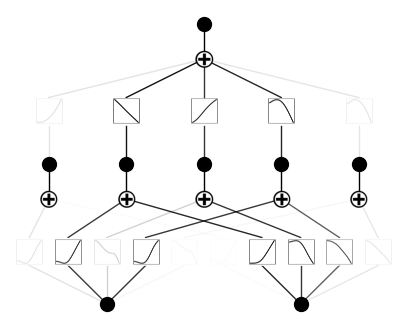

In [301]:
model(dataset['train_input'])
model.plot()

In [302]:
model.fit(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.)

| train_loss: 6.72e-01 | test_loss: 6.94e-01 | reg: 2.10e+00 | : 100%|█| 20/20 [00:11<00:00,  1.68it

saving model version 0.1


{'train_loss': [array(0.6715653, dtype=float32),
  array(0.6715105, dtype=float32),
  array(0.6715097, dtype=float32),
  array(0.67152655, dtype=float32),
  array(0.6716297, dtype=float32),
  array(0.67164403, dtype=float32),
  array(0.6716449, dtype=float32),
  array(0.6716454, dtype=float32),
  array(0.6716454, dtype=float32),
  array(0.67164546, dtype=float32),
  array(0.6716472, dtype=float32),
  array(0.67164505, dtype=float32),
  array(0.6716451, dtype=float32),
  array(0.67164505, dtype=float32),
  array(0.67164505, dtype=float32),
  array(0.67164516, dtype=float32),
  array(0.67164487, dtype=float32),
  array(0.6716439, dtype=float32),
  array(0.6716439, dtype=float32),
  array(0.671644, dtype=float32)],
 'test_loss': [array(0.69274646, dtype=float32),
  array(0.6930097, dtype=float32),
  array(0.6929776, dtype=float32),
  array(0.6927927, dtype=float32),
  array(0.69359136, dtype=float32),
  array(0.6936346, dtype=float32),
  array(0.69363713, dtype=float32),
  array(0.6936387

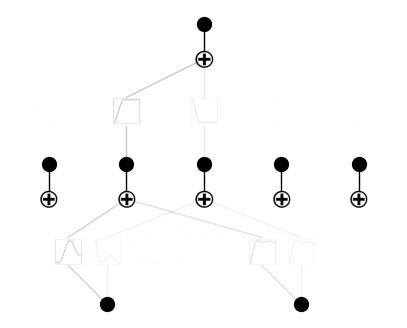

In [303]:
model.plot()

In [304]:
#model = model.prune()
#model.plot()

In [305]:
dataset

{'train_input': tensor([[-0.6787,  0.9383],
         [ 0.4889, -0.6731],
         [ 0.8728,  1.0554],
         ...,
         [ 0.5502,  0.6043],
         [ 0.0740, -0.8004],
         [-0.0973, -1.5325]]),
 'train_label': tensor([-8.8997e-01, -8.6197e-01, -1.9900e-01,  4.1893e-01,  1.6800e-01,
          6.5455e-01,  3.5092e-01,  5.3364e-01,  1.8748e-01, -8.2828e-01,
         -1.2594e-01,  1.1892e+00,  2.5618e-02,  1.0266e+00, -5.0013e-01,
         -8.3207e-01, -9.3646e-01,  9.5887e-01, -1.0816e+00, -8.8973e-01,
         -2.1730e-01, -3.1301e-01, -1.2163e+00, -1.1765e+00, -7.5555e-01,
          3.9586e-01, -1.4921e-01, -2.4506e-01, -3.5358e-01, -1.2651e-02,
          2.2608e-01, -2.1157e-01, -6.6050e-03, -2.6051e-01,  1.3060e-01,
         -1.1915e+00,  1.4144e-01, -2.0588e-01,  1.2230e+00,  1.3990e-01,
         -1.0342e+00, -9.2253e-01, -1.0516e+00, -8.6268e-01, -6.4820e-01,
          5.5766e-01, -1.6202e-01, -5.9914e-01, -1.2398e+00, -1.2295e+00,
          4.9708e-01, -7.7881e-01, -2.20

In [306]:
model.fit(dataset, opt="LBFGS", steps=50)


| train_loss: 6.72e-01 | test_loss: 6.93e-01 | reg: 4.92e-01 | : 100%|█| 50/50 [00:08<00:00,  6.04it

saving model version 0.2


{'train_loss': [array(0.6715097, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.67150956, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.67150956, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.67150956, dtype=float32),
  array(0.67150956, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.67150956, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.67150956, dtype=float32),
  array(0.67150956, dtype=float32),
  array(0.67150956, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.67150956, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.67150956, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.67150956, dtype=float

In [307]:
model = model.refine(10)


saving model version 0.3


In [308]:
model.fit(dataset, opt="LBFGS", steps=50)


| train_loss: 6.72e-01 | test_loss: 6.93e-01 | reg: 1.67e+00 | : 100%|█| 50/50 [00:09<00:00,  5.09it

saving model version 0.4


{'train_loss': [array(0.6715117, dtype=float32),
  array(0.67151034, dtype=float32),
  array(0.6715102, dtype=float32),
  array(0.67151016, dtype=float32),
  array(0.67151, dtype=float32),
  array(0.67150986, dtype=float32),
  array(0.67150986, dtype=float32),
  array(0.6715098, dtype=float32),
  array(0.6715098, dtype=float32),
  array(0.6715098, dtype=float32),
  array(0.67150974, dtype=float32),
  array(0.67150974, dtype=float32),
  array(0.67150974, dtype=float32),
  array(0.67150974, dtype=float32),
  array(0.67150974, dtype=float32),
  array(0.67150974, dtype=float32),
  array(0.67150974, dtype=float32),
  array(0.6715097, dtype=float32),
  array(0.6715097, dtype=float32),
  array(0.6715097, dtype=float32),
  array(0.67150974, dtype=float32),
  array(0.6715097, dtype=float32),
  array(0.6715097, dtype=float32),
  array(0.6715097, dtype=float32),
  array(0.6715097, dtype=float32),
  array(0.6715097, dtype=float32),
  array(0.6715097, dtype=float32),
  array(0.6715097, dtype=float3

In [309]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.5462371110916138, c=1
fixing (0,0,1) with x, r2=0.7544311881065369, c=1
fixing (0,0,2) with x, r2=0.05122623220086098, c=1
fixing (0,0,3) with x, r2=0.7394543886184692, c=1
fixing (0,0,4) with x, r2=0.23722417652606964, c=1
fixing (0,1,0) with x, r2=0.4221404790878296, c=1
fixing (0,1,1) with x, r2=0.30845966935157776, c=1
fixing (0,1,2) with x, r2=0.1976027935743332, c=1
fixing (0,1,3) with x, r2=0.17970818281173706, c=1
fixing (0,1,4) with x, r2=0.4090868830680847, c=1
fixing (1,0,0) with x, r2=0.07286247611045837, c=1
fixing (1,1,0) with x, r2=0.02677699364721775, c=1
fixing (1,2,0) with x, r2=0.40380793809890747, c=1
fixing (1,3,0) with x, r2=0.4763643145561218, c=1
fixing (1,4,0) with x, r2=0.012977773323655128, c=1
saving model version 0.5


In [310]:
model.fit(dataset, opt="LBFGS", steps=50)


| train_loss: 6.72e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | : 100%|█| 50/50 [00:07<00:00,  6.51it

saving model version 0.6


{'train_loss': [array(0.6715097, dtype=float32),
  array(0.6715097, dtype=float32),
  array(0.6715097, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.67150956, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715097, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  array(0.6715096, dtype=float32),
  arr

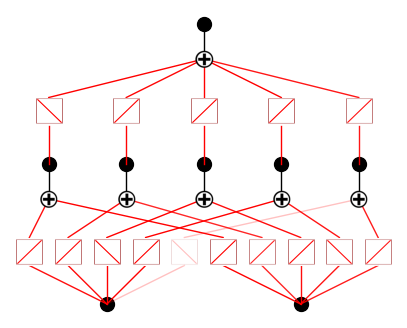

In [313]:
model.plot()

In [312]:
from kan.utils import ex_round
ex_round(model.symbolic_formula()[0][0],4)


-0.1559